## Imports

In [2]:
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataset import CoconutDataset, collate_fn
from config import Config
from model import Coconut
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

/users/eleves-b/2021/julien.genzling/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## Prosqa dataset 

In [3]:
with open(f"data/prosqa_valid.json") as f:
    data = json.load(f)

In [4]:
data[1]

{'question': 'Sally is a zhorpus. Every yumpus is a fompus. Every zhorpus is a rempus. Every rompus is a sterpus. Every kerpus is a timpus. Stella is a yumpus. Every zhorpus is a zumpus. Every wumpus is a yumpus. Sally is a rempus. Stella is a wumpus. Every zumpus is a rorpus. Sally is a rompus. Every numpus is a bompus. Every zumpus is a scrompus. Every rempus is a kerpus. Every zumpus is a vumpus. Every timpus is a yerpus. Every rempus is a numpus. Every vumpus is a worpus. Every rompus is a felpus. Every wumpus is a sterpus. Every rompus is a kerpus. Every zumpus is a rempus. Every rempus is a chorpus. Bob is a rorpus. Every wumpus is a fompus. Sally is a kerpus. Every zhorpus is a rompus. Is Sally a fompus or worpus?',
 'answer': 'Sally is a worpus.',
 'steps': ['Sally is a zhorpus.',
  'Every zhorpus is a zumpus.',
  'Every zumpus is a vumpus.',
  'Every vumpus is a worpus.'],
 'idx_to_symbol': ['Stella',
  'Sally',
  'zhorpus',
  'zumpus',
  'rompus',
  'rempus',
  'wumpus',
  'y

In [5]:
def visualize_prosqa_graph_fixed(data):
    """
    Creates a visualization of a ProSQA dataset sample with enhanced visibility.
    
    Parameters:
    data (dict): A dictionary containing ProSQA dataset item with keys:
                'idx_to_symbol', 'edges', 'steps', 'root', 'target', 'neg_target',
                'question', and 'answer'.
    """
    # Create an undirected graph
    G = nx.Graph()
    
    # Add nodes
    for i, symbol in enumerate(data["idx_to_symbol"]):
        G.add_node(i, label=symbol)
    
    # Add edges
    for source, target in data["edges"]:
        G.add_edge(source, target)
    
    # Extract reasoning path edges
    steps = data["steps"]
    reasoning_path_edges = []
    
    # Get node IDs for the reasoning path
    for i in range(len(steps) - 1):
        current_step = steps[i]
        next_step = steps[i + 1]
        
        # Extract entity names from steps
        current_entity = current_step.split(" is a ")[0]
        current_predicate = current_step.split(" is a ")[1].rstrip(".")
        next_entity = next_step.split(" is a ")[0]
        next_predicate = next_step.split(" is a ")[1].rstrip(".")
        
        # Find node IDs
        if i == 0:  # First step
            source_idx = data["idx_to_symbol"].index(current_entity)
            target_idx = data["idx_to_symbol"].index(current_predicate)
            reasoning_path_edges.append((source_idx, target_idx))
        
        # Connect predicates
        source_idx = data["idx_to_symbol"].index(current_predicate)
        target_idx = data["idx_to_symbol"].index(next_predicate)
        reasoning_path_edges.append((source_idx, target_idx))
    
    # Create a position layout with more spread
    pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42)
    
    # Create a figure with white background and larger size
    plt.figure(figsize=(20, 16), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')
    
    # Draw nodes with enhanced visibility
    node_colors = []
    node_sizes = []
    node_borders = []
    border_widths = []
    
    for node in G.nodes():
        if node == data["root"]:  # Root node (Tom)
            node_colors.append("#bdffbd")  # Darker green
            node_sizes.append(5000)
            node_borders.append("black")
            border_widths.append(2.0)
        elif node == data["target"]:  
            node_colors.append("#bdcaff")  
            node_sizes.append(5000)
            node_borders.append("black")
            border_widths.append(2.0)
        elif node == data["neg_target"]:  
            node_colors.append("#DDDDDD") 
            node_sizes.append(5000)
            node_borders.append("#888888")
            border_widths.append(2.0)
        else:
            node_colors.append("#DDDDDD") # Lighter gray
            node_sizes.append(5000)
            node_borders.append("#888888")
            border_widths.append(1.0)
    
    # Draw all edges in light gray with increased width
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color="#AAAAAA")
    
    # Highlight the reasoning path from steps
    reasoning_path = []
    current_node = data["root"]  # Tom
    
    # First, add the direct edge from root to the first step
    first_step = data["steps"][0]
    first_predicate = first_step.split(" is a ")[1].rstrip(".")
    first_predicate_idx = data["idx_to_symbol"].index(first_predicate)
    reasoning_path.append((data["root"], first_predicate_idx))
    
    # Then add edges between consecutive predicates
    for i in range(len(data["steps"]) - 1):
        current_predicate = data["steps"][i].split(" is a ")[1].rstrip(".")
        next_predicate = data["steps"][i+1].split(" is a ")[1].rstrip(".")
        current_predicate_idx = data["idx_to_symbol"].index(current_predicate)
        next_predicate_idx = data["idx_to_symbol"].index(next_predicate)
        reasoning_path.append((current_predicate_idx, next_predicate_idx))
    
    # Draw the reasoning path edges in bold red
    nx.draw_networkx_edges(G, pos, edgelist=reasoning_path, width=3.0, alpha=1, 
                          edge_color="black")
    
    # Draw nodes last so they're on top of the edges
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                          edgecolors=node_borders, linewidths=border_widths)
    
    # Add labels with larger font
    labels = {node: data["idx_to_symbol"][node] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=16, 
                           font_color="black")
    
    # Make the legend more visible
    plt.legend(loc="upper right", fontsize=14, frameon=True, 
              facecolor='white', edgecolor='black', title="Legend",
              title_fontsize=16)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the steps text
    plt.axis("off")
    plt.show()

/tmp/ipykernel_899771/931508297.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=14, frameon=True,


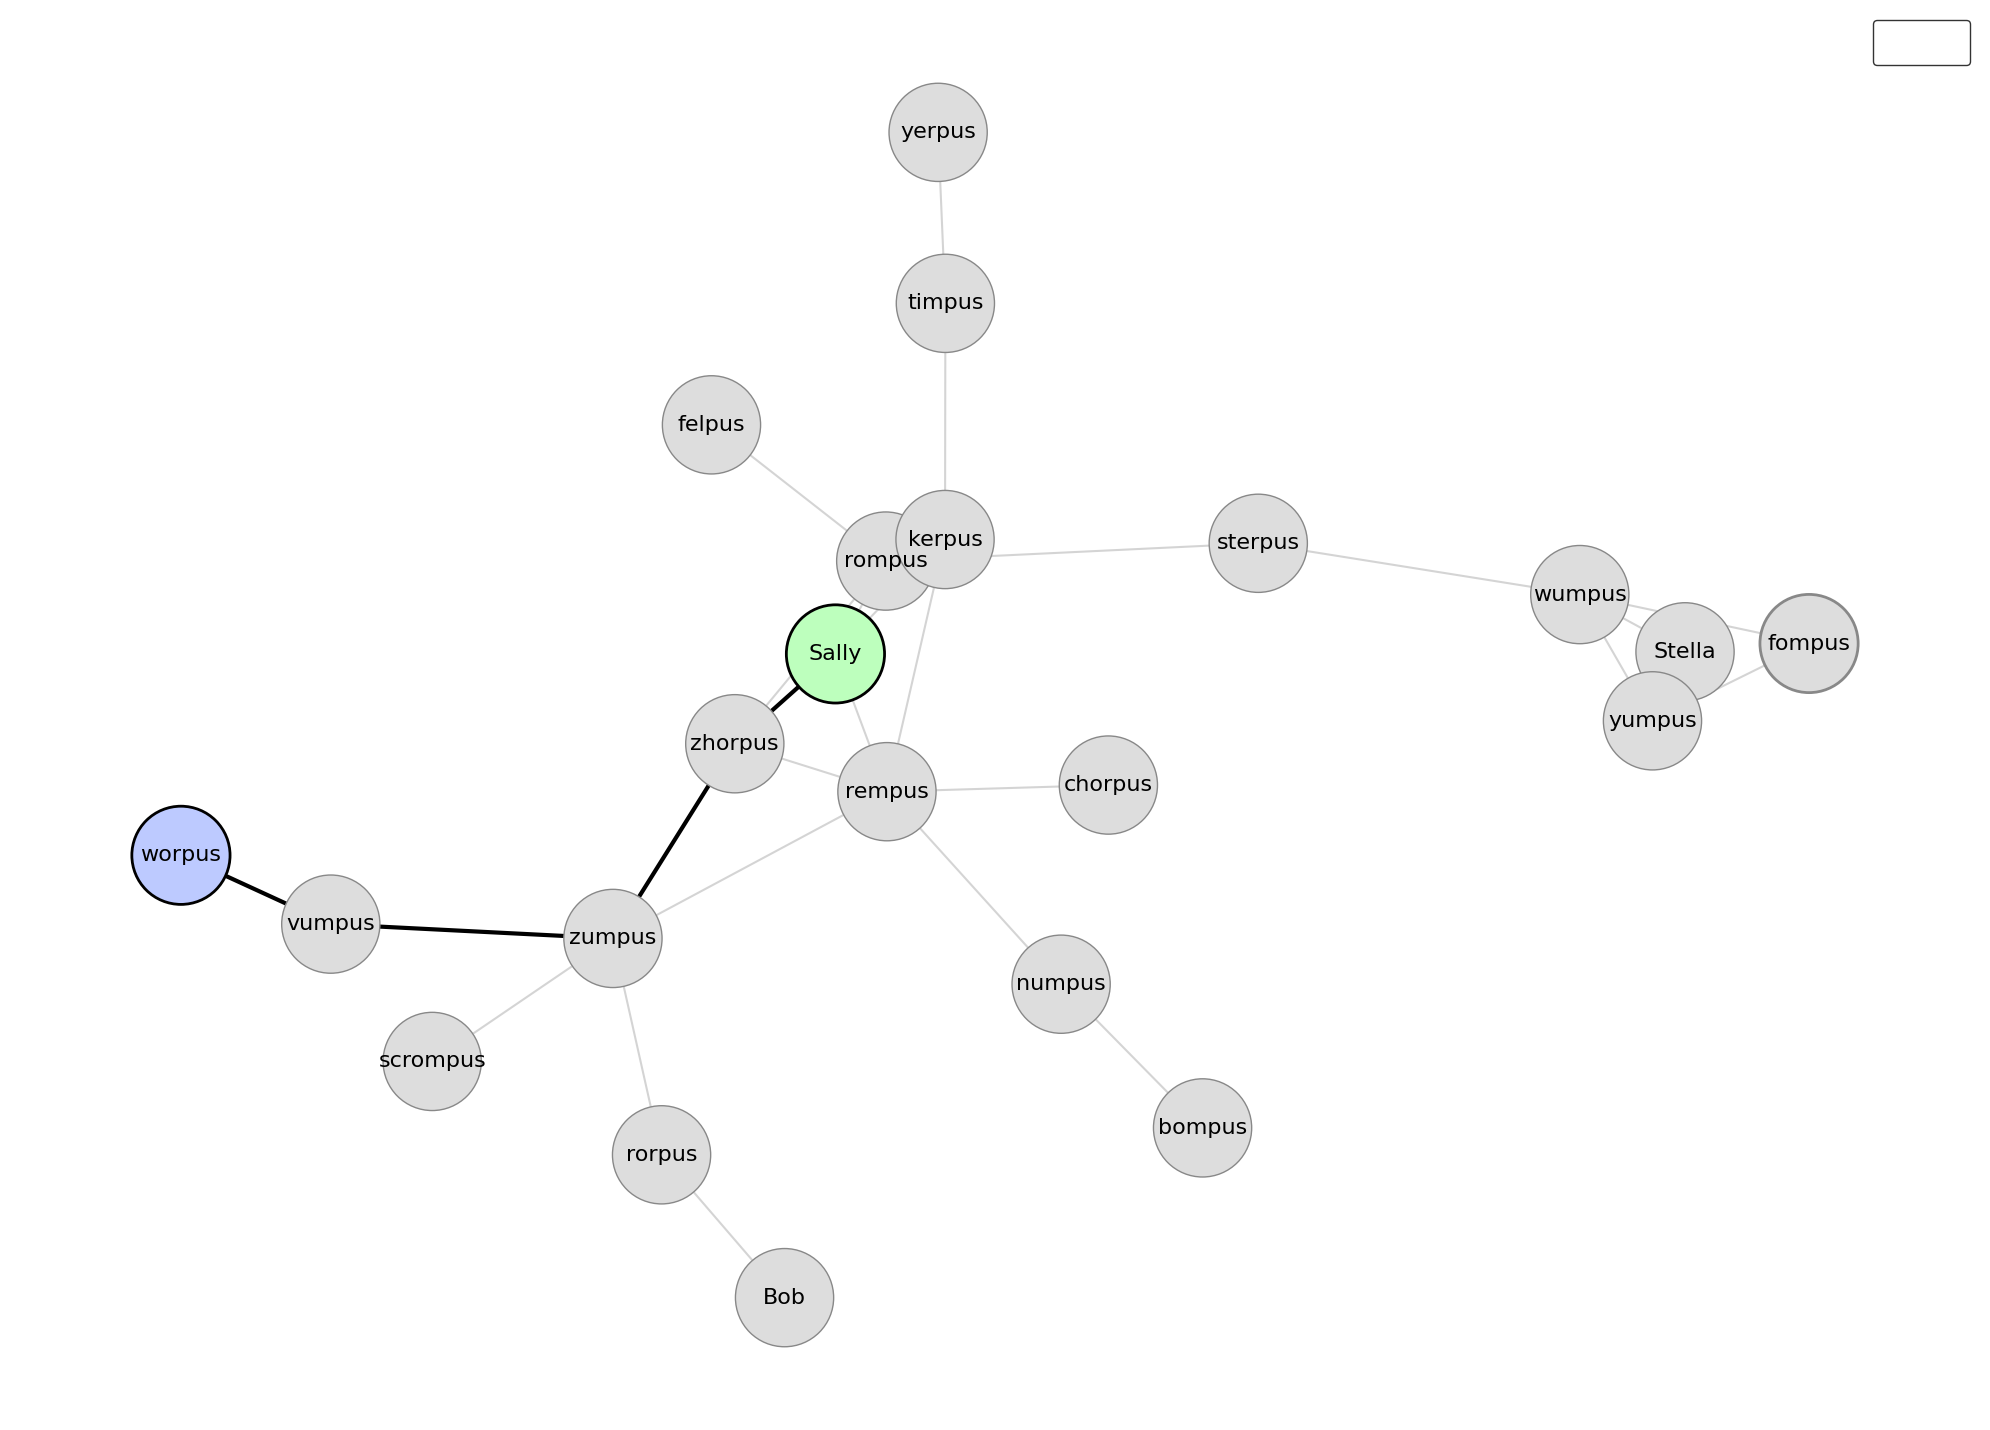

In [6]:
visualize_prosqa_graph_fixed(data[1])

## Coconut

In [7]:
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens("<|start-latent|>")
tokenizer.add_tokens("<|end-latent|>")
tokenizer.add_tokens("<|latent|>")
latent_id = tokenizer.convert_tokens_to_ids("<|latent|>")
start_id = tokenizer.convert_tokens_to_ids("<|start-latent|>")
end_id = tokenizer.convert_tokens_to_ids("<|end-latent|>")
model.resize_token_embeddings(len(tokenizer))
embeddings = model.get_input_embeddings()
target_id = tokenizer.convert_tokens_to_ids("<<")
for token_id in [latent_id, start_id, end_id]:
    target_embedding = embeddings.weight.data[target_id]
    embeddings.weight.data[token_id] = target_embedding
model = Coconut(model, latent_id, tokenizer.eos_token_id)

model.load_state_dict(torch.load("/users/eleves-b/2021/julien.genzling/best-prosqa-coconut"))

model.to(Config.device)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Coconut(
  (base_causallm): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50260, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_featu

In [8]:
dataset_val = CoconutDataset(
        name="prosqa",
        train_or_val="valid",
        modality="coconut",
        stage=0,
        debug = True,
        tokenizer=tokenizer,
        start_id=start_id,
        end_id=end_id,
        latent_id=latent_id,
        c=1,
    )
collate = partial(collate_fn, tokenizer=tokenizer, latent_id=latent_id)
valid_gen_dataloader = torch.utils.data.DataLoader(
    dataset_val,
    num_workers=1,
    pin_memory=True,
    batch_size=1,
    collate_fn=collate,
)

In [9]:
question_val = [
    d["question"] for d in json.load(open(f"data/prosqa_valid.json"))
]
answers_val = [
    d["answer"].replace(",", "").strip()
    for d in json.load(open(f"data/prosqa_valid.json"))
]
cot_val = [
    "\n".join(d["steps"]) for d in json.load(open(f"data/prosqa_valid.json"))
]

In [10]:
correct = torch.tensor(0, device=Config.device)
correct_cot = torch.tensor(0, device=Config.device)
total = torch.tensor(0, device=Config.device)
model.eval()
with torch.no_grad():
    for batch in tqdm(valid_gen_dataloader):
        test_idx = batch["idx"][0]

        batch = {
            k: v.to(Config.device)
            for k, v in batch.items()
            if v != None and k not in ["idx", "position_ids"]
        }

        answer = answers_val[test_idx.cpu().item()]
        answer_cot = cot_val[test_idx.cpu().item()]
        question = question_val[test_idx.cpu().item()]

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model.generate(**batch, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

        text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer_output = text_output.split("#")[-1].replace(",", "").strip()
        cot_output = ("\n".join(text_output.split("\n")[1:])).split("#")[0].strip()

        correct += answer_output == answer
        correct_cot += cot_output == answer_cot
        total += 1
        
test_accuracy = correct / total
cot_accuracy = correct_cot / total
print(
        f"Validation accuracy: {test_accuracy:.2f} | CoT validation match: {cot_accuracy:.2f}"
    )


  0%|          | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  5%|▌         | 1/20 [00:00<00:07,  2.59it/s]

Every shumpus is a rempus. Every shumpus is a yimpus. Every terpus is a fompus. Every terpus is a gerpus. Every gerpus is a brimpus. Alex is a rempus. Every rorpus is a scrompus. Every rorpus is a yimpus. Every terpus is a brimpus. Every brimpus is a lempus. Tom is a terpus. Every shumpus is a timpus. Every yimpus is a boompus. Davis is a shumpus. Every gerpus is a lorpus. Davis is a fompus. Every shumpus is a boompus. Every shumpus is a rorpus. Every terpus is a lorpus. Every boompus is a timpus. Every fompus is a yerpus. Tom is a dumpus. Every rempus is a rorpus. Is Tom a lempus or scrompus?
<|start-latent|><|end-latent|>### Tom is a lempus.
Sally is a zhorpus. Every yumpus is a fompus. Every zhorpus is a rempus. Every rompus is a sterpus. Every kerpus is a timpus. Stella is a yumpus. Every zhorpus is a zumpus. Every wumpus is a yumpus. Sally is a rempus. Stella is a wumpus. Every zumpus is a rorpus. Sally is a rompus. Every numpus is a bompus. Every zumpus is a scrompus. Every rempu

 20%|██        | 4/20 [00:00<00:03,  4.78it/s]

Every shumpus is a yumpus. Every worpus is a yimpus. Every shumpus is a gwompus. Every tumpus is a boompus. Every worpus is a shumpus. Every storpus is a terpus. Max is a yimpus. Every shumpus is a rompus. Every wumpus is a jelpus. Every boompus is a terpus. Fae is a tumpus. Every tumpus is a worpus. Every rompus is a gorpus. Every timpus is a impus. Every jompus is a gerpus. Every boompus is a rompus. Fae is a boompus. Every boompus is a kerpus. Every zumpus is a bompus. Max is a rempus. Every rompus is a kerpus. Max is a impus. Every rempus is a impus. Every wumpus is a yumpus. Every grimpus is a terpus. Every tumpus is a jompus. Every yumpus is a felpus. Every jelpus is a felpus. Every shumpus is a felpus. Every rempus is a timpus. Every storpus is a jompus. Every rompus is a storpus. Every tumpus is a wumpus. Every wumpus is a jompus. Every boompus is a worpus. Fae is a storpus. Every worpus is a jelpus. Every grimpus is a felpus. Every worpus is a yumpus. Every rempus is a zumpus.

 25%|██▌       | 5/20 [00:01<00:02,  5.03it/s]

Every yerpus is a gerpus. Every boompus is a shumpus. Every dumpus is a hilpus. Oliver is a zumpus. Oliver is a yerpus. Sally is a dumpus. Every grimpus is a tumpus. Every worpus is a dumpus. Every worpus is a hilpus. Every scrompus is a terpus. Every yerpus is a quimpus. Every terpus is a felpus. Every yerpus is a boompus. Every boompus is a zumpus. Every boompus is a rorpus. Every yerpus is a scrompus. Every yerpus is a sterpus. Every boompus is a grimpus. Every yerpus is a yumpus. Every terpus is a lempus. Every zumpus is a shumpus. Sally is a worpus. Every gerpus is a terpus. Every yumpus is a boompus. Every scrompus is a yumpus. Every yerpus is a zumpus. Oliver is a chorpus. Is Oliver a hilpus or tumpus?
<|start-latent|><|end-latent|>Every grimpus is a tumpus.
### Oliver is a tumpus.


 35%|███▌      | 7/20 [00:01<00:02,  5.91it/s]

Every dumpus is a boompus. Sally is a numpus. Sally is a worpus. Every grimpus is a hilpus. Every hilpus is a chorpus. Every rorpus is a bompus. Every numpus is a grimpus. Every yumpus is a quimpus. Every dumpus is a yumpus. Every shumpus is a jompus. Every grimpus is a terpus. Every kerpus is a gwompus. Rex is a shumpus. Every hilpus is a lempus. Every yumpus is a tumpus. Every kerpus is a lorpus. Every gorpus is a grimpus. Every quimpus is a tumpus. Every numpus is a gorpus. Every worpus is a hilpus. Every grimpus is a kerpus. Every numpus is a worpus. Sally is a gorpus. Rex is a dumpus. Every kerpus is a rorpus. Every gorpus is a worpus. Every terpus is a rorpus. Every worpus is a impus. Is Sally a bompus or boompus?
<|start-latent|><|end-latent|>Every rorpus is a bompus.
### Sally is a bompus.
Every felpus is a chorpus. Every fompus is a felpus. Every terpus is a zumpus. Every dumpus is a yumpus. Davis is a zhorpus. Every terpus is a felpus. Every terpus is a chorpus. Oliver is a g

 50%|█████     | 10/20 [00:01<00:01,  6.78it/s]

Tom is a zhorpus. Every impus is a sterpus. Every yerpus is a shumpus. Every wumpus is a shumpus. Tom is a bompus. Every worpus is a zumpus. Every rompus is a jelpus. Every rempus is a zhorpus. Every bompus is a impus. Every yerpus is a bompus. Every zumpus is a tumpus. Every bompus is a sterpus. Every impus is a chorpus. Every zumpus is a lempus. Every rempus is a jelpus. Every wumpus is a jelpus. Every rempus is a yerpus. Every yerpus is a gerpus. Every gerpus is a bompus. Every terpus is a gorpus. Eva is a gwompus. Every gorpus is a numpus. Every rompus is a terpus. Every wumpus is a sterpus. Every wumpus is a yerpus. Every yerpus is a chorpus. Every shumpus is a bompus. Every wumpus is a bompus. Every zhorpus is a gerpus. Every worpus is a gwompus. Every wumpus is a zhorpus. Eva is a rompus. Tom is a rempus. Eva is a worpus. Every zhorpus is a lempus. Every shumpus is a impus. Every rempus is a wumpus. Every shumpus is a gerpus. Every worpus is a jelpus. Every zhorpus is a bompus. 

 55%|█████▌    | 11/20 [00:01<00:01,  5.96it/s]

Every zhorpus is a rompus. Every gwompus is a timpus. Every gerpus is a yumpus. Every zhorpus is a yumpus. Sally is a jompus. Every gerpus is a worpus. Every lorpus is a vumpus. Every vumpus is a worpus. Every yimpus is a brimpus. Every zhorpus is a yimpus. Every chorpus is a terpus. Every worpus is a fompus. Every fompus is a scrompus. Every lorpus is a shumpus. Every tumpus is a numpus. Every impus is a yumpus. Rex is a tumpus. Alex is a vumpus. Every shumpus is a vumpus. Alex is a dumpus. Every rompus is a scrompus. Every vumpus is a gerpus. Every shumpus is a dumpus. Every dumpus is a gerpus. Every wumpus is a chorpus. Every vumpus is a wumpus. Alex is a worpus. Every lorpus is a scrompus. Every fompus is a wumpus. Every shumpus is a worpus. Every gerpus is a impus. Every tumpus is a zhorpus. Every vumpus is a scrompus. Every tumpus is a rompus. Every lorpus is a worpus. Every fompus is a chorpus. Every gwompus is a numpus. Every rompus is a gwompus. Every gwompus is a boompus. Eve

 60%|██████    | 12/20 [00:02<00:01,  5.58it/s]

Every hilpus is a rompus. Rex is a bompus. Every gerpus is a hilpus. Tom is a rorpus. Every bompus is a fompus. Every fompus is a storpus. Tom is a gorpus. Gabriel is a rompus. Every rorpus is a gerpus. Every gorpus is a gerpus. Every bompus is a sterpus. Every sterpus is a felpus. Every yerpus is a gerpus. Every yerpus is a gwompus. Every fompus is a timpus. Every rorpus is a gorpus. Tom is a gwompus. Rex is a storpus. Every sterpus is a timpus. Tom is a quimpus. Every rorpus is a yerpus. Every gerpus is a lempus. Every gwompus is a lempus. Rex is a quimpus. Every bompus is a zhorpus. Rex is a sterpus. Is Tom a timpus or rompus?
<|start-latent|><|end-latent|>Every hilpus is a rompus.
### Tom is a rompus.


 70%|███████   | 14/20 [00:02<00:01,  5.38it/s]

Every worpus is a quimpus. Every lempus is a wumpus. Every brimpus is a gwompus. Every worpus is a impus. Every dumpus is a terpus. Every impus is a fompus. Every gerpus is a yumpus. Every grimpus is a numpus. Every grimpus is a shumpus. Every gwompus is a quimpus. Every numpus is a yimpus. Every gwompus is a hilpus. Every quimpus is a impus. Every zhorpus is a shumpus. Every grimpus is a dumpus. Every dumpus is a lempus. Wren is a grimpus. Every wumpus is a fompus. Every terpus is a timpus. Every yimpus is a jelpus. Every wumpus is a gerpus. Every bompus is a worpus. Every lempus is a yumpus. Every wumpus is a yimpus. Every terpus is a zhorpus. Every grimpus is a zhorpus. Every brimpus is a shumpus. Every terpus is a wumpus. Every dumpus is a jelpus. Gabriel is a worpus. Every terpus is a lempus. Gabriel is a bompus. Gabriel is a timpus. Every yimpus is a shumpus. Every wumpus is a numpus. Every worpus is a brimpus. Is Wren a hilpus or yumpus?
<|start-latent|><|end-latent|>Every gerpu

 80%|████████  | 16/20 [00:02<00:00,  5.23it/s]

Every rompus is a brimpus. Bob is a rompus. Every worpus is a sterpus. Every zhorpus is a jompus. Bob is a zhorpus. Every rompus is a jompus. Polly is a tumpus. Every gerpus is a yerpus. Polly is a vumpus. Polly is a zumpus. Every shumpus is a dumpus. Every gerpus is a hilpus. Every wumpus is a yerpus. Every hilpus is a gwompus. Every zumpus is a vumpus. Every felpus is a vumpus. Every shumpus is a brimpus. Every gerpus is a gwompus. Bob is a jompus. Every hilpus is a quimpus. Every zumpus is a felpus. Every rompus is a quimpus. Every rompus is a jelpus. Every felpus is a yerpus. Polly is a felpus. Every vumpus is a scrompus. Every felpus is a tumpus. Every brimpus is a rorpus. Every jelpus is a shumpus. Every vumpus is a tumpus. Every hilpus is a wumpus. Every zumpus is a tumpus. Every scrompus is a sterpus. Every zhorpus is a rompus. Every rompus is a gerpus. Every scrompus is a worpus. Every wumpus is a bompus. Every jelpus is a jompus. Alex is a quimpus. Is Bob a tumpus or bompus?


 90%|█████████ | 18/20 [00:03<00:00,  6.91it/s]

Every zumpus is a timpus. Every sterpus is a lorpus. Every lorpus is a lempus. Every zumpus is a chorpus. Every timpus is a yerpus. Every kerpus is a yimpus. Davis is a fompus. Every bompus is a impus. Every shumpus is a gorpus. Every jompus is a grimpus. Every bompus is a gerpus. Every storpus is a zhorpus. Every terpus is a yimpus. Rex is a gorpus. Every kerpus is a yumpus. Every gwompus is a vumpus. Every impus is a grimpus. Bob is a timpus. Every impus is a jompus. Every yerpus is a lempus. Bob is a sterpus. Every gerpus is a grimpus. Every kerpus is a shumpus. Every bompus is a jompus. Every lorpus is a yimpus. Davis is a gwompus. Every lorpus is a storpus. Every zumpus is a yimpus. Every impus is a gerpus. Every gorpus is a yumpus. Every fompus is a zhorpus. Bob is a fompus. Every zumpus is a sterpus. Every gorpus is a yimpus. Davis is a bompus. Every lorpus is a kerpus. Every chorpus is a lempus. Every sterpus is a timpus. Every storpus is a terpus. Every yumpus is a yimpus. Bob

 95%|█████████▌| 19/20 [00:03<00:00,  6.44it/s]

Every wumpus is a storpus. Every zhorpus is a grimpus. Every brimpus is a gerpus. Stella is a zhorpus. Every wumpus is a rempus. Every fompus is a zhorpus. Every lorpus is a worpus. Every worpus is a numpus. Every grimpus is a yerpus. Every brimpus is a vumpus. Polly is a sterpus. Every rompus is a lorpus. Every wumpus is a rompus. Every fompus is a yerpus. Every gwompus is a jompus. Every grimpus is a storpus. Tom is a fompus. Every fompus is a gorpus. Polly is a gwompus. Every wumpus is a fompus. Every sterpus is a gwompus. Every storpus is a felpus. Every wumpus is a zhorpus. Every sterpus is a brimpus. Every brimpus is a jompus. Tom is a wumpus. Every vumpus is a gerpus. Every rompus is a yerpus. Jack is a grimpus. Every wumpus is a grimpus. Every sterpus is a terpus. Polly is a brimpus. Every lorpus is a dumpus. Every fompus is a dumpus. Every grimpus is a worpus. Is Tom a numpus or terpus?
<|start-latent|><|end-latent|>Every worpus is a numpus.
### Tom is a numpus.


100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

Every storpus is a scrompus. Every lorpus is a timpus. Every felpus is a yimpus. Every jelpus is a numpus. Alex is a chorpus. Every dumpus is a numpus. Every terpus is a felpus. Stella is a yumpus. Every bompus is a lorpus. Every scrompus is a gwompus. Every gerpus is a brimpus. Every worpus is a rempus. Every storpus is a timpus. Every chorpus is a rempus. Every quimpus is a brimpus. Stella is a rempus. Every bompus is a gerpus. Every chorpus is a quimpus. Every yumpus is a jelpus. Every worpus is a zumpus. Every gorpus is a numpus. Every chorpus is a bompus. Every chorpus is a terpus. Every chorpus is a storpus. Every gorpus is a zumpus. Every gerpus is a rorpus. Every chorpus is a gwompus. Stella is a gorpus. Every jelpus is a zumpus. Every worpus is a yumpus. Every gwompus is a kerpus. Every gorpus is a worpus. Every bompus is a gwompus. Every chorpus is a scrompus. Every jelpus is a dumpus. Alex is a quimpus. Every storpus is a rempus. Sally is a rempus. Is Alex a numpus or yimpus

## COT

In [ ]:
model = AutoModelForCausalLM.from_pretrained('openai-community/gpt2')
tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens("<|start-latent|>")
tokenizer.add_tokens("<|end-latent|>")
tokenizer.add_tokens("<|latent|>")
latent_id = tokenizer.convert_tokens_to_ids("<|latent|>")
start_id = tokenizer.convert_tokens_to_ids("<|start-latent|>")
end_id = tokenizer.convert_tokens_to_ids("<|end-latent|>")
model.resize_token_embeddings(len(tokenizer))
embeddings = model.get_input_embeddings()
target_id = tokenizer.convert_tokens_to_ids("<<")
for token_id in [latent_id, start_id, end_id]:
    target_embedding = embeddings.weight.data[target_id]
    embeddings.weight.data[token_id] = target_embedding
model = Coconut(model, latent_id, tokenizer.eos_token_id)

model.load_state_dict(torch.load("/users/eleves-b/2021/julien.genzling/best-prosqa-cot"))

model.to(Config.device)